# Results plots

This notebook contains all the results plots using all the data extracted from the `main/pick_best_models.py` script with the `conf/tyra.yaml` configuration file. This plots will use different levels of treatment: `dnbr` and `frp` under different population of vegetation: `conifers` , `shrublands`, and `all` (removing all urban and agricultural areas). The outcomes are the following:
 - **dnbr**: The difference between the pre and post fire NBR values.
 - **frp**: The Fire Radiative Power (FRP) values.
 - **emissions**: The emissions values.

Following the `tyra` configuration, the best results and weights for each combination of treatment and vegetation type are stored in the `best_models/` folder with treatment and vegetation best weights and balancing results according with `loss` and `asmd`, our two metrics of interest during the optimization process in the `main/balancing.py`.  

In [1]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from prescribed.estimate.calculate_estimator import calculate_estimator
from prescribed.utils import prepare_template

In [2]:
# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 14

In [13]:
conifers_loss = {
    "std_diffs_dnbr": pd.read_csv(
        "../best_models/dnbr_treatment/best_model_loss_std_diffs.csv"
    ),
    "std_diffs_frp": pd.read_csv(
        "../best_models/frp_treatment/best_model_loss_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        "../best_models/dnbr_treatment/best_model_loss_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        "../best_models/frp_treatment/best_model_loss_weights.csv"
    ),
}

shrubs_loss = {
    "std_diffs_dnbr": pd.read_csv(
        "../best_models/dnbr_treat_shrubs/best_model_loss_std_diffs.csv"
    ),
    "std_diffs_frp": pd.read_csv(
        "../best_models/frp_treat_shrubs/best_model_loss_std_diffs.csv"
    ),
    "weights_dnbr": pd.read_csv(
        "../best_models/dnbr_treat_shrubs/best_model_loss_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        "../best_models/frp_treat_shrubs/best_model_loss_weights.csv"
    ),
}

In [63]:
def plot_std_diffs(std_diffs_df, palette="Blues", drop_vars=None, ax=None, save_path=None):
    """Plot Standarized Absolute Mean Differences as an array

    Parameters
    ----------
    std_diffs_df : pd.DataFrame
        DataFrame with the Standarized Absolute Mean Differences
    palette : str
        Color palette to use in the plot
    ax : matplotlib.axes.Axes, optional
        Axes object
    save_path : str, optional
        Path to save the plot, by default None. If None, the plot is not saved
    drop_vars : list, optional
        List of variables to drop from the plot, by default None

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object
    """

    # Create a covar family for some of the variables that are timeseries
    # Add family_covar column to the dataframe to aggregate covariates
    std_diffs_df["family_covar"] = [
        "_".join([i for i in c.split("_") if not i.isdigit()])
        for c in std_diffs_df.covar.tolist()
    ]

    std_diffs_grouped = (
        std_diffs_df.groupby(["family_covar", "focal_year"], as_index=False)[
            [
                "std_weighted_asmd",
                "std_unweighted_asmd",
                "std_unweighted_smd",
                "std_weighted_smd",
            ]
        ]
        .mean()
        .sort_values(["std_unweighted_asmd"])
    )

    if drop_vars is not None:
        std_diffs_grouped = std_diffs_grouped[
            ~std_diffs_grouped.family_covar.isin(drop_vars)
        ]

    # Create pivot table to represent data as an array
    asmd_unweighted_array = pd.pivot_table(
        std_diffs_grouped,
        index="family_covar",
        columns="focal_year",
        values="std_weighted_asmd",
    )

    # Create a figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    # Adjust the space between the subplots
    plt.subplots_adjust(wspace=0, hspace=0.2)

    # Plot the array
    # Pre-sort the rows of the array to have the largest values at the bottom
    sorted_arr = asmd_unweighted_array.loc[
        asmd_unweighted_array.mean(axis=1).sort_values(ascending=False).index
    ]

    # Top code all values above 0.2 as 0.2
    arr = sorted_arr.values
    cax = ax.imshow(arr, cmap=palette)

    # Add a colorbar to the plot and a title to the colorbar
    cbar = plt.colorbar(cax)
    cbar.set_label("Absolute Standarized Mean Differences", size=12)

    # Add the labels to the x and y axis using the family_covar and focal_year from the std_diffs_grouped dataframe. The x labels should be in the bottom of the plot
    ax.set_xticks(np.arange(len(sorted_arr.columns)), labels=sorted_arr.columns)
    ax.set_yticks(range(len(sorted_arr.index)), labels=sorted_arr.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Remove the box (frame) around the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    return ax

Text(0.5, 1.0, 'Shrubs - FRP')

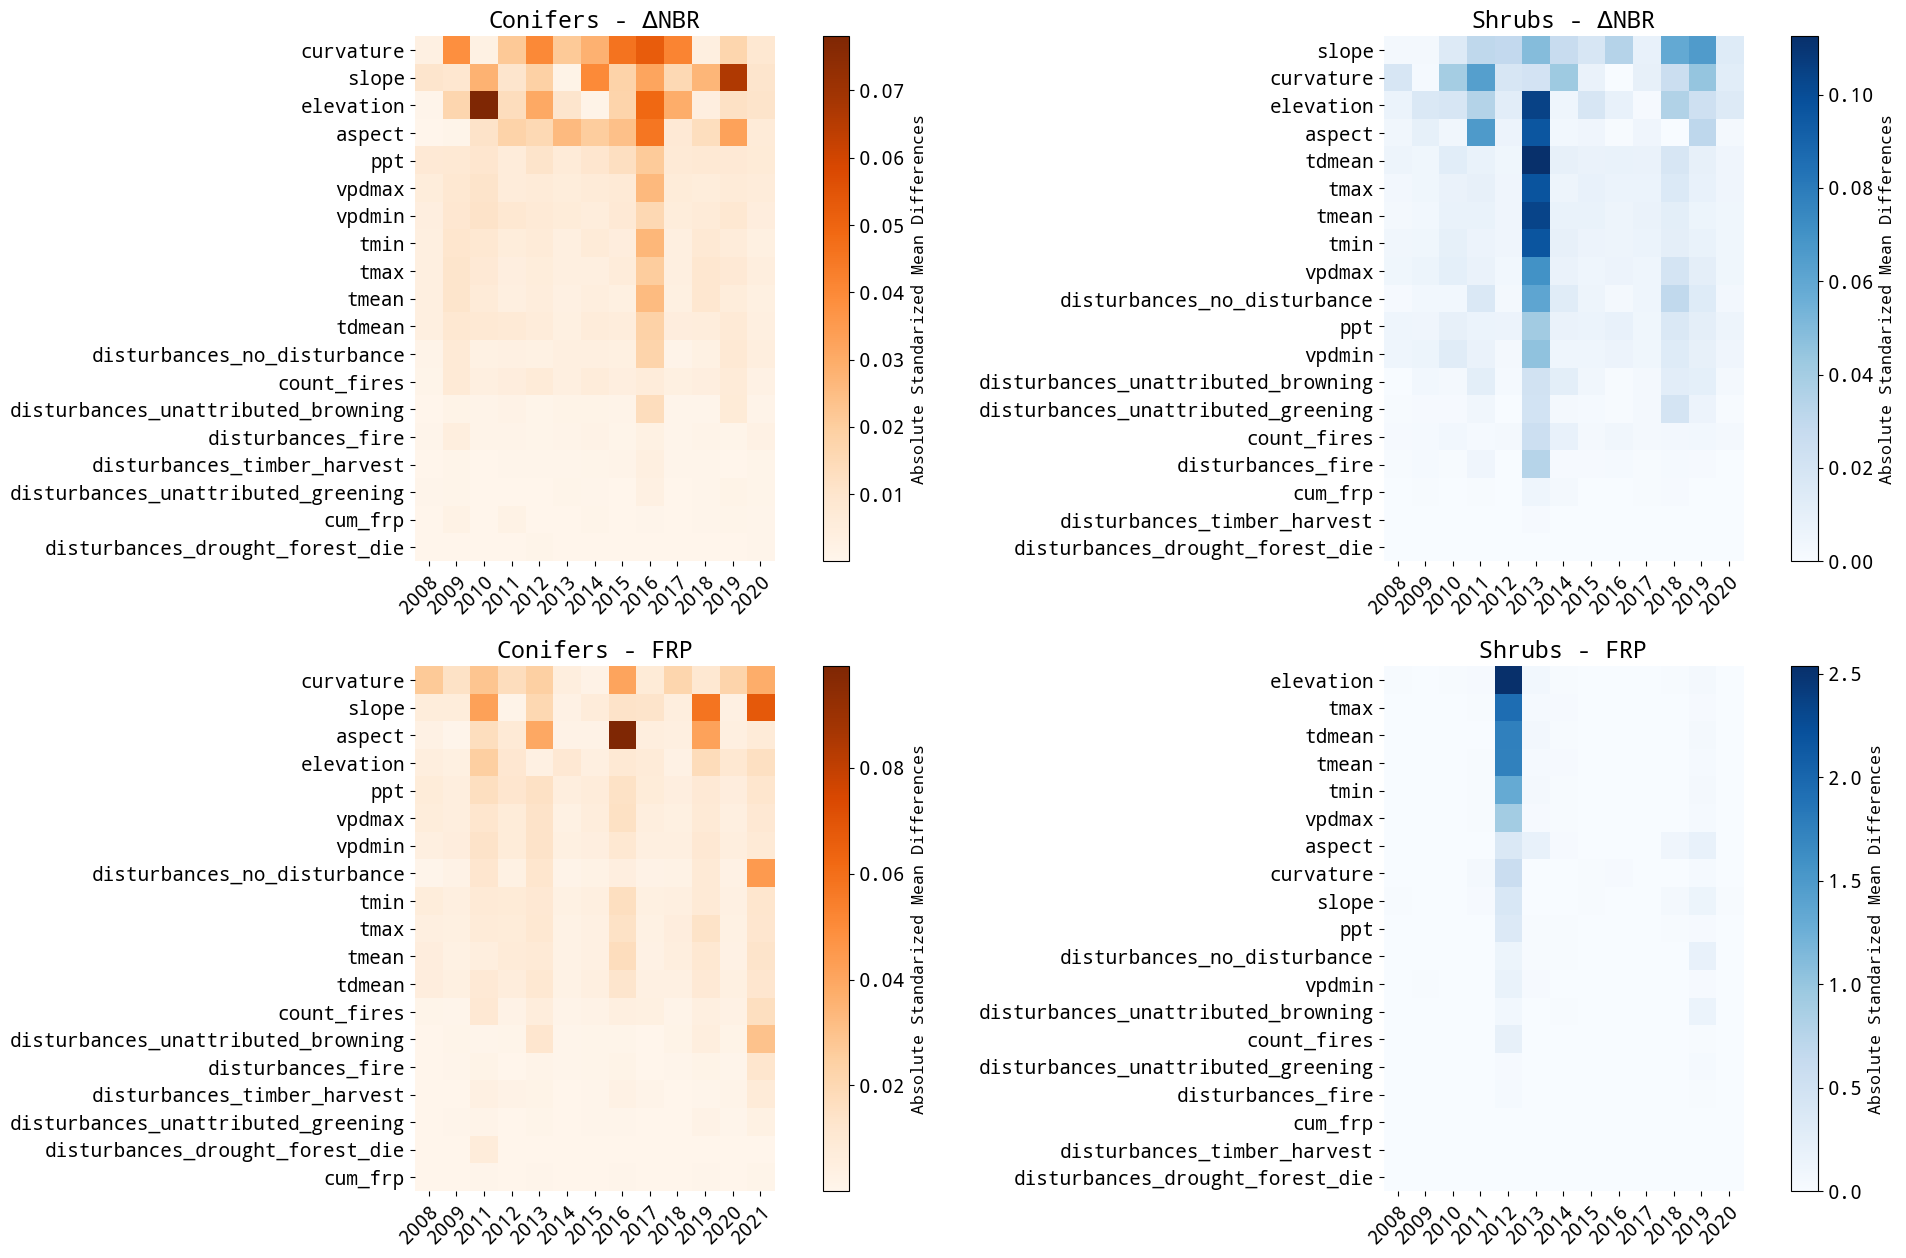

In [72]:
fig, ax = plt.subplots(2, 2, figsize=(25, 15))
plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_dnbr"], palette="Oranges",
    drop_vars=["Intercept", "land_type"],  ax=ax[0, 0]
)
plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_frp"], palette="Oranges",
    drop_vars=["Intercept", "land_type"],  ax=ax[1, 0]
)

plot_std_diffs(std_diffs_df=shrubs_loss["std_diffs_dnbr"], palette="Blues", ax=ax[0, 1], 
               drop_vars=["Intercept", "land_type"]
)
plot_std_diffs(std_diffs_df=shrubs_loss["std_diffs_frp"], palette="Blues", 
               drop_vars=["Intercept", "land_type"], ax=ax[1, 1])

# At text on the first column
ax[0, 0].set_title(r"Conifers - $\Delta$NBR")
ax[1, 0].set_title("Conifers - FRP")
ax[0, 1].set_title(r"Shrubs - $\Delta$NBR")
ax[1, 1].set_title("Shrubs - FRP")


In [6]:
def plot_loss_check(path_to_losses, best_model_path):
    """Plot losses

    This is not a plot meant for production, just a quick way to checck the CV
    losses of the models
    """

    paths = list(Path(path_to_losses).rglob("*.parquet"))

    best_model = pd.read_csv(best_model_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    for path in paths:
        loss = pd.read_parquet(path)
        if loss.model_run_id.unique()[0] in best_model["model_run_id"].tolist():
            reg = loss.reg.unique()[0]
            lr = loss.lr

            # Plot loss
            ax[0].plot(loss.loss, label=f"Reg: {reg} - LR: {lr}")
            ax[1].plot(loss.lr_decay, label=f"Reg: {reg} - LR: {lr}")

            ax[0].set_ylabel("Loss")
            ax[0].set_xlabel("Iterations")
            ax[0].set_yscale("log")

            ax[1].set_ylabel("Learning Rate")
            ax[1].set_xlabel("Iterations")
            ax[1].set_yscale("log")

    # Make some space between the axis
    fig.tight_layout()
    plt.show()

    return ax

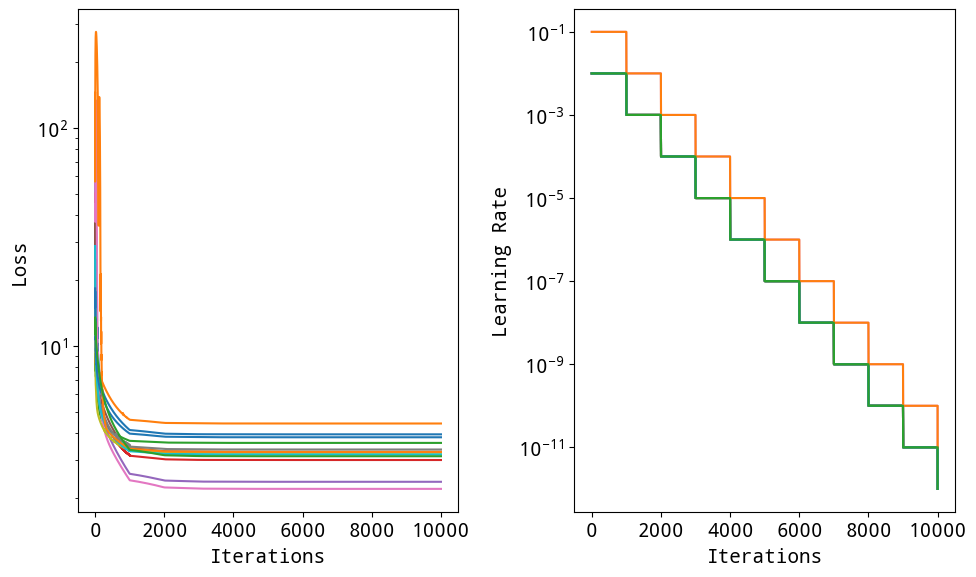

array([<Axes: xlabel='Iterations', ylabel='Loss'>,
       <Axes: xlabel='Iterations', ylabel='Learning Rate'>], dtype=object)

In [7]:
plot_loss_check(
    path_to_losses="/mnt/sherlock/scratch/dnbr_treatment/loss",
    best_model_path="../best_models/dnbr_treatment/best_model_loss.csv",
)

In [57]:
def plot_std_diffs_focal_year(
    std_diffs, focal_year, ax=None, save_path=None, drop_vars=None
):
    """Plot Standarized Mean Differences for a specific focal year"""

    std_diffs_year = std_diffs[std_diffs.focal_year == focal_year]

    # Group by family_covar and focal_year
    std_diffs_year = (
        std_diffs_year.groupby(["family_covar", "focal_year"], as_index=False)[
            [
                "std_weighted_asmd",
                "std_unweighted_asmd",
                "std_unweighted_smd",
                "std_weighted_smd",
            ]
        ]
        .mean()
        .sort_values(["std_unweighted_asmd"])
    )

    if drop_vars is not None:
        std_diffs_year = std_diffs_year[~std_diffs_year.family_covar.isin(drop_vars)]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        std_diffs_year["std_weighted_smd"].sort_values(),
        std_diffs_year["family_covar"],
        "o",
        label="Weighted",
    )
    ax.plot(
        std_diffs_year["std_unweighted_smd"].sort_values(),
        std_diffs_year["family_covar"],
        "o",
        label="Unweighted",
    )
    ax.axvline(0, color="black", linestyle="--")
    ax.axvline(-0.1, color="black", linestyle="--")
    ax.axvline(0.1, color="black", linestyle="--")

    # Add more ticks to the x axis from -0.5 to 0.5
    ax.set_xticks(np.round(np.arange(-0.5, 0.5, 0.1), 1))
    ax.set_xticklabels(np.round(np.arange(-0.5, 0.5, 0.1), 1))

    # Add labels to axis
    ax.set_ylabel("Variables")
    ax.set_xlabel("Standardized Differences")

    # Add legend to the plot
    ax.legend()

    # Make plot nicer by removing top and right spines and moving the ticks outward
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines.left.set_position(("outward", 10))
    ax.spines.bottom.set_position(("outward", 10))
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.tick_params(axis="both", which="major", labelsize=12)

    # Save the plot
    if save_path:
        plt.savefig(
            os.path.join(save_path, f"std_diffs_{focal_year}.png"),
            bbox_inches="tight",
            dpi=300,
        )

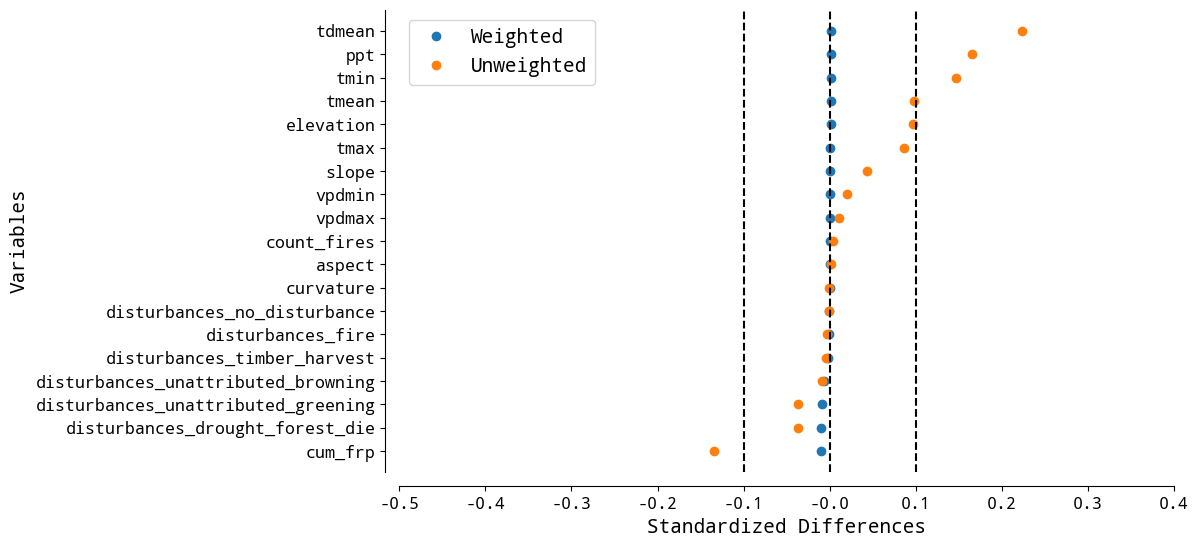

In [58]:
plot_std_diffs_focal_year(conifers_loss["std_diffs_dnbr"], 2020, drop_vars=["Intercept", "land_type"])

## Inference

In [10]:
# Load data
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id")
    .first()
)

wide_treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments/wide_treats.feather"
)

frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp/frp_concat.feather"
)

dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr/dnbr_long.feather"
)

mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

emissions = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_pm25/emissions_long.feather"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

# Re-do dnbr to get years
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID"
)

paths_severity = list(
    Path("/mnt/sherlock/oak/prescribed_data/raw/emissions/emission_CA").rglob("*.grd")
)

mtbs_ca_sample = mtbs_ca[
    mtbs_ca.Event_ID.isin([p.stem.split("_")[0].upper() for p in paths_severity])
]

# Merge emissions with mtbs to get year
emissions = emissions.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)
not_matched = emissions[emissions.Event_ID.isna()]
not_matched["california"] = not_matched.event_id.apply(lambda x: x.split("_")[0][:2])
not_matched["year"] = not_matched.event_id.apply(lambda x: int(x.split("_")[0][2:6]))

emissions = pd.concat(
    [emissions[~emissions.Event_ID.isna()], not_matched[not_matched.california == "CA"]]
)

/tmp/ipykernel_942170/2357153081.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_matched["california"] = not_matched.event_id.apply(lambda x: x.split("_")[0][:2])
/tmp/ipykernel_942170/2357153081.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_matched["year"] = not_matched.event_id.apply(lambda x: int(x.split("_")[0][2:6]))


In [34]:
def plot_outcomes(
    df_conifer,
    df_shrub,
    var_interest,
    axes_names,
    cmap_conifer="Oranges",
    cmap_shrub="Blues",
    legend=False,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    df_conifer[(df_conifer.lag > 0) & (df_conifer.focal_year <= 2020)].plot.scatter(
        x="lag",
        y=var_interest,
        c="focal_year",
        cmap=cmap_conifer,
        ax=ax,
        alpha=0.5,
        colorbar=False,
    )

    df_shrub[(df_shrub.lag > 0) & (df_shrub.focal_year <= 2020)].plot.scatter(
        x="lag",
        y=var_interest,
        c="focal_year",
        cmap=cmap_shrub,
        ax=ax,
        alpha=0.5,
        colorbar=False,
    )

    sns.regplot(
        x="lag",
        y=var_interest,
        data=df_conifer[(df_conifer.focal_year <= 2020)],
        scatter=False,
        ax=ax,
        color="#fdc086",
        robust=True,
        label="Conifers",
    )

    sns.regplot(
        x="lag",
        y=var_interest,
        data=df_shrub[(df_shrub.focal_year <= 2020)],
        scatter=False,
        ax=ax,
        color="#a6cee3",
        robust=True,
        label="Shrublands",
    )

    if legend:
        ax.legend(loc="upper right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    ax.axhline(0, color="black", linestyle="--", c="gray")

    x_lab, y_lab = axes_names
    ax.set_ylabel(x_lab)
    ax.set_xlabel(y_lab)

    return ax

In [21]:
# Estimate effects for conifers
df_frp = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_frp"],
    outcomes=frp,
    focal_year=range(2008, 2021),
    outcome_var="frp",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_dnbr = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr,
    focal_year=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

# Do the same for shrubs
df_frp_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_frp"],
    outcomes=frp,
    focal_year=range(2008, 2021),
    outcome_var="frp",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_dnbr_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=dnbr,
    focal_year=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_emissions = calculate_estimator(
    treatments=wide_treatments,
    weights=conifers_loss["weights_dnbr"],
    outcomes=emissions[emissions.year <= 2020],
    focal_year=range(2008, 2021),
    outcome_var="PM2.5",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

df_emissions_shurbs = calculate_estimator(
    treatments=wide_treatments,
    weights=shrubs_loss["weights_dnbr"],
    outcomes=emissions[emissions.year <= 2020],
    focal_year=range(2008, 2021),
    outcome_var="PM2.5",
    low_treatment_class=[2, 1],
    lag_up_to=2021,
)

Calculating estimator per focal year...:   0%|          | 0/13 [00:00<?, ?it/s]/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatments_year.loc[:, "treat"] = (
Calculating estimator per focal year...:   8%|▊         | 1/13 [00:00<00:03,  3.56it/s]/home/topcat/projects/extract/src/prescribed/estimate/calculate_estimator.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatments_year.loc[:, "treat"] = (
Calculating estimato

(0.0, 1.0, 0.0, 1.0)

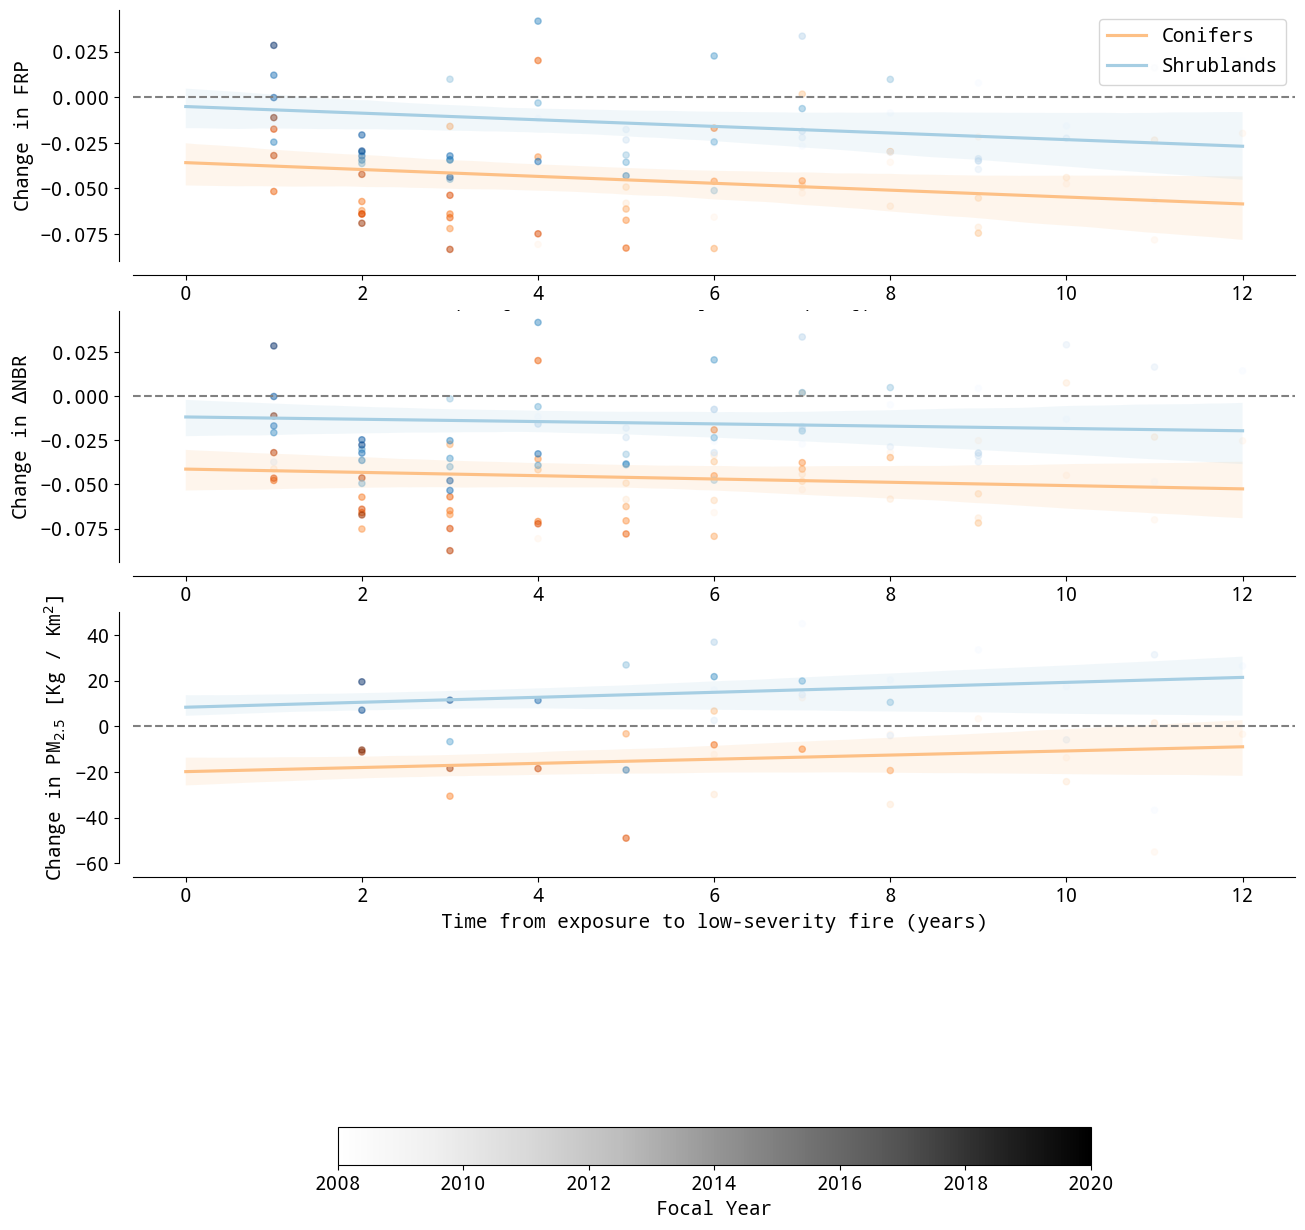

In [49]:
fig, ax = plt.subplots(4, 1, figsize=(15, 15))
plot_outcomes(
    df_conifer=df_dnbr,
    df_shrub=df_dnbr_shurbs,
    var_interest="delta_frp",
    axes_names=("Change in FRP", "Time from exposure to low-severity fire (years)"),
    ax=ax[0],
    legend=True,
)
plot_outcomes(
    df_conifer=df_dnbr,
    df_shrub=df_dnbr_shurbs,
    var_interest="delta_dnbr",
    axes_names=(
        r"Change in $\Delta$NBR",
        "Time from exposure to low-severity fire (years)",
    ),
    ax=ax[1],
)
plot_outcomes(
    df_conifer=df_emissions,
    df_shrub=df_emissions_shurbs,
    var_interest="delta_dnbr",
    axes_names=(
        r"Change in PM$_{2.5}$ [Kg / Km$^{2}$]",
        "Time from exposure to low-severity fire (years)",
    ),
    ax=ax[2],
)

# Create a custom colorbar with a different colormap

# Get the position of axs[2]
pos = ax[2].get_position()
ax[3].set_position([pos.x0, pos.y0 - 0.05, pos.width, 0.02])

norm = Normalize(vmin=2008, vmax=2020)
mappable = ScalarMappable(cmap="Greys", norm=norm)
mappable.set_array([])

cbar = fig.colorbar(mappable, ax=ax[3], orientation="horizontal")
cbar.set_label("Focal Year")
ax[3].axis("off")